# Classification. Linear models and KNN

In [1490]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1491]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix, accuracy_score, make_scorer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from seaborn import heatmap

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [1492]:
PATH = "./data/"

In [1493]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [1494]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1495]:
data.shape

(891, 11)

In [1496]:
test_data.shape

(418, 10)

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [1497]:
data['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [1498]:
data['Sex'].value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

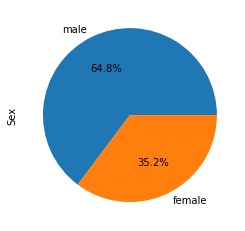

In [1499]:
data['Sex'].value_counts().plot.pie(autopct='%.1f%%');

We see that 64% is male 36% is female. Total amount of males is 577 and females is 314.

In [1500]:
data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

61% of all passengers are not survived, 39% are survived. To check whether we have dependency of Survived from Sex let group them and count amount in each group.

In [1501]:
sex_survived_grouped = data[['Sex', 'Survived']].groupby(by=['Sex', 'Survived']).size()

In [1502]:
sex_survived_grouped

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

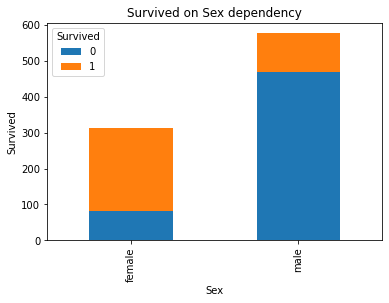

In [1503]:
sex_survived_grouped.unstack().plot(kind='bar', stacked=True)
plt.ylabel('Survived')
plt.title('Survived on Sex dependency');

In [1504]:
data[['Sex', 'Survived']].replace({"female":1, 'male':0}).corr()

,Sex,Survived
Sex,1.000000,0.543351
Survived,0.543351,1.000000


We see from the histogram that most of females survived, and most males are not. Correlation between Sex and Survived features is 0.54.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

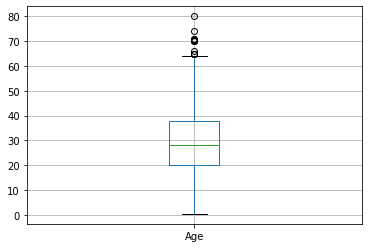

In [1505]:
data.boxplot(column='Age');

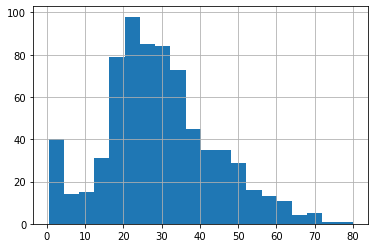

In [1506]:
data['Age'].hist(bins=20);

In [1507]:
data['Age'].apply([np.median, np.mean, np.max, np.min])

median    28.000000
mean      29.699118
amax      80.000000
amin       0.420000
Name: Age, dtype: float64

We see that most of passengers is between 20 and 40 years. Median value is 28 years, mean is 29.6, max is 80 and min is 0.4.
Let's check what is age distribution for survived and deceased passengers. We can think that survived passengers are smarter or they were richer, but we can't see it from this graphs, it requires additional investigation.

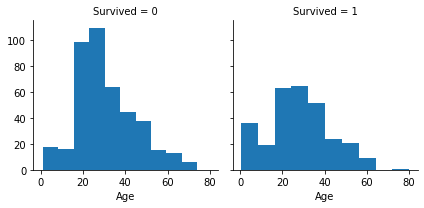

In [1508]:
age_grid = sns.FacetGrid(data=data, col='Survived')
age_grid.map(plt.hist, 'Age');

We see from histogram above that deceseased passengers are a bit younger than survived.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Let's first look at pie charts for PClass and Embarked features

In [1509]:
data['Pclass'].value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

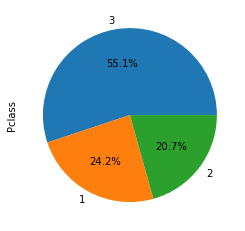

In [1510]:
data['Pclass'].value_counts().plot.pie(autopct='%.1f%%');

We see that 55% of passengers have class 3, 21% class 2 and 24% class 1.
Let's now check how Survived feature depends on Pclass. For that we will plot distribution for every Pclass (green is survived, red is deceased)

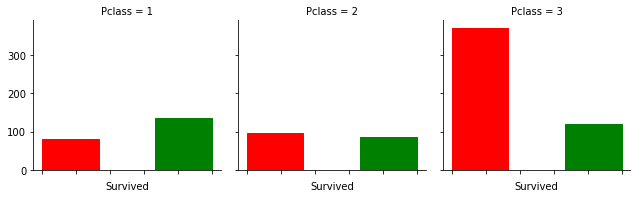

In [1511]:
def plot_survived_grid(grid):
    grid.map(plt.hist, 'Survived', bins = 3)
    for ax in grid.axes.flat:
        ax.patches[0].set_color('r')
        ax.patches[2].set_color('g')
        ax.set_xticklabels([])

pclass_grid = sns.FacetGrid(data=data, col='Pclass')
plot_survived_grid(pclass_grid)

We clearly see from graph above that passengers of class 3 had much smaller chances to survive. Class 1 and Class 2 are similiar, but Class 1 passengers had slightly better chances to survive.

In [1512]:
data['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

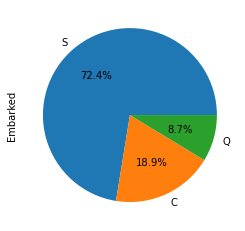

In [1513]:
data['Embarked'].value_counts().plot.pie(autopct='%.1f%%');

72% of passengers have Southampton as port of Embarkation, 19% Cherbourg and 9% Queenstown. For 2 passengers we don't know embarkation port.

Lets explore now if there is any relationship between the embarkation port and the survival.

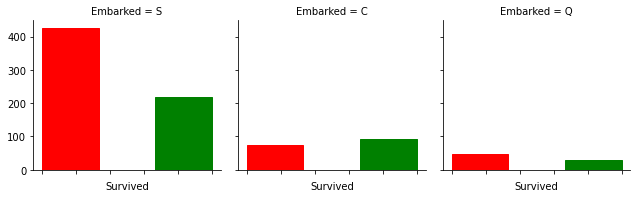

In [1514]:
embarked_grid = sns.FacetGrid(data=data, col='Embarked')
plot_survived_grid(embarked_grid)

We see that passengers with port of embarkation Southampton are twice more likely to not survive. For other two ports chances are approximately equal.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [1515]:
data.isna().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
Fare        0.000000
Ticket      0.000000
Parch       0.000000
SibSp       0.000000
Sex         0.000000
Name        0.000000
Pclass      0.000000
Survived    0.000000
dtype: float64

In [1516]:
test_data.isna().mean().sort_values(ascending=False)

Cabin       0.782297
Age         0.205742
Fare        0.002392
Embarked    0.000000
Ticket      0.000000
Parch       0.000000
SibSp       0.000000
Sex         0.000000
Name        0.000000
Pclass      0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We see that 3 features have missing values. Let's explore every one separately.
First lets look at Cabin feature.

In [1517]:
data['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [1518]:
data['Cabin'].value_counts(dropna=False).head()

NaN            687
C23 C25 C27      4
B96 B98          4
G6               4
C22 C26          3
Name: Cabin, dtype: int64

We see that we have 687 missing values, almost all values are different. Let's look additionaly for which Pclass we don't have cabin information.

In [1519]:
data[data['Cabin'].isna()]['Pclass'].value_counts()

3    479
2    168
1     40
Name: Pclass, dtype: int64

Mostly we don't have information about Cabin for Class 3. Let's look from other angle, if we know Cabin what is a Pclass

In [1520]:
data[~data['Cabin'].isna()]['Pclass'].value_counts()

1    176
2     16
3     12
Name: Pclass, dtype: int64

We see that if Cabin feature has not NaN value it almost always means Pclass is 1. That means features are strongly correlated and we can drop this feature, as information is contained in Pclass feature. Other way to handle this would be to change Cabin factor to boolean "IsCabinNA" and set it to True. One more option is to extract letter from Cabin and anaylyze titanic scheme. I tried both with droping Cabin and with setting IsCabinNA and in my case dropping worked a little bit better.

In [1521]:
# i will do all modifications in data_cleaned data frame
data_cleaned = data.copy()
# data_cleaned['IsCabinNA'] = data_cleaned['Cabin'].isna()
data_cleaned = data_cleaned.drop(columns=['Cabin'])

Lets now look at Age column.

In [1522]:
data_cleaned['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [1523]:
data_cleaned['Age'].value_counts(dropna=False)

NaN      177
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
66.00      1
23.50      1
0.42       1
Name: Age, Length: 89, dtype: int64

In [1524]:
data_cleaned[data_cleaned['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,S


For 177 of 891 passengers we don't know Age. It's almost 20% of all data and we can't just drop this, especially when we saw earlier that younger passengers a little bit less chances to survive. Simple approach would be to impute missed values here with mean value. I did this in first version of this notebook. But quality was not so good and i found in Internet discussions suggestion to impute age based on average Age of age group. I took idea of separation in groups by title, all code is written by myself.

In [1525]:
# that was my first attempt
# data_cleaned.loc[data_cleaned['Age'].isna(), 'Age'] = data_cleaned['Age'].mean()

# here we try to impute Age for each group from Name
# in second position is title of person (if it exists)
# if title is rare let's set it to Unknown
data_cleaned['Name'].str.split().str[1].value_counts().head(10)

Mr.        502
Miss.      179
Mrs.       121
Master.     40
Dr.          7
Rev.         6
y            4
Impe,        3
Planke,      3
Gordon,      2
Name: Name, dtype: int64

In [1526]:
age_group = {'Mr.' : 0, 'Miss.' : 1, 'Mrs.' : 2, 'Master' : 3, 'Dr.' : 4, 'Unknown' : 5}

def get_age_group(s):
    for k,v in age_group.items():
        if k in s:
            return v
    return age_group['Unknown']

data_cleaned['AgeGroup'] = data_cleaned['Name'].apply(get_age_group)

In [1527]:
mean_age_group = data_cleaned.groupby(by='AgeGroup')[['Age', 'AgeGroup']].mean()
mean_age_group

,Age,AgeGroup
AgeGroup,,
0,32.368090,0
1,21.773973,1
2,35.898148,2
3,4.574167,3
4,42.000000,4
5,42.500000,5


In [1528]:
joined = data_cleaned.join(mean_age_group, on='AgeGroup', rsuffix='_mean')
data_cleaned.loc[data_cleaned['Age'].isna(), 'Age'] = joined[data_cleaned['Age'].isna()]['Age_mean']
data_cleaned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [1529]:
# check that we filled all n/a values
data_cleaned['Age'].isna().sum()

0

Last feature with missed values is Embarked. We have only two missed rows - we can just throw these 2 rows. Another possible way would be to change it for example to some random port, but result would be probably the same and not significant. As it's the last column with missed values we can just drop all NaN left.

In [1530]:
data_cleaned['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [1531]:
data_cleaned = data_cleaned.dropna()
data_cleaned.shape

(889, 11)


With shape attr we confirm that only two rows were dropped.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [1532]:
data_cleaned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


As ML algorithms require from us only numeric values, let's transform not numeric values.

In [1533]:
data_cleaned.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Embarked     object
AgeGroup      int64
dtype: object

We see that Name, Sex, Ticket and Embarked have type object, i.e. string type. Let's handle it

In [1534]:
data_cleaned['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 889, dtype: object

For Name column we can try to extract some information from Name (see previout part for age group detection and imputation of missed values from mean for this group)
Except for this let's just skip Name column.

For Sex column let's just use One-Hot Encoding. Will use pandas.get_dummies method for this.

In [1535]:
data_cleaned = pd.get_dummies(data_cleaned, columns=['Sex'])

Next feature is Ticket. We have 680 unique values

In [1536]:
data_cleaned['Ticket'].nunique()

680

In [1537]:
data_cleaned['Ticket'].value_counts()

347082              7
CA. 2343            7
1601                7
CA 2144             6
3101295             6
                   ..
C.A./SOTON 34068    1
365222              1
350052              1
315094              1
9234                1
Name: Ticket, Length: 680, dtype: int64

Not unique values are possible to use to try group passengers by tickets. But we will not use this feature for now.

For Embarked column lets use One-Hot encoding. And the same for Pclass and AgeGroup - because it's categorical feature, it's better to encode it as well. After this drop Name and Ticket

In [1538]:
data_cleaned = pd.get_dummies(data_cleaned, columns=['Embarked', 'Pclass', 'AgeGroup'])
data_cleaned = data_cleaned.drop(columns=['Name', 'Ticket'])

In [1539]:
data_cleaned.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,1,0,0,0,0,0
2,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0,0,1,0,0,0
3,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,1,0,0,0,0
4,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0,0,1,0,0,0
5,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,1,0,0,0,0,0


Now data is in numeric format and is almost ready for experiment.
Let's look at pairplot for some of pairs of features first. We see that fare vs age is very mixed. it can be source of difficulty for classification (but for now i don't know how to separate them)

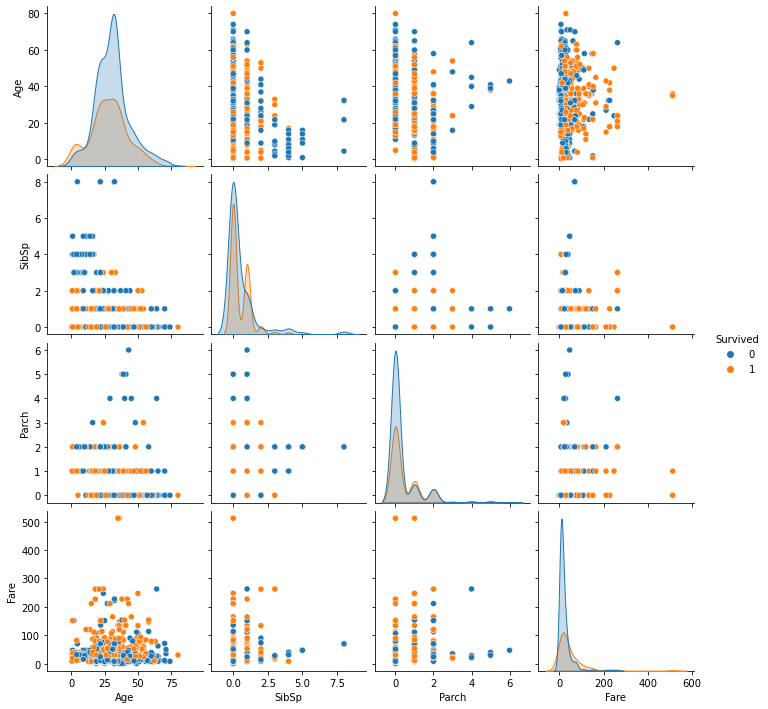

In [1540]:
sns.pairplot(data_cleaned[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']], hue = 'Survived');

Now let's try simple algorithms without tuning hyperparameters.
Just run cross-validation on simple logistic regression, and then on knn.

In [1541]:
features_to_use = list(data_cleaned.columns)
features_to_use.remove('Survived')
y = data_cleaned['Survived']
X = data_cleaned[features_to_use]

In [1542]:
logreg_model = LogisticRegression(solver='liblinear', penalty='l1', random_state=33)
logreg_pipeline = make_pipeline(StandardScaler(), logreg_model)

cv_logreg_scores = cross_val_score(logreg_pipeline, X, y, scoring='accuracy', cv=5)
cv_logreg_scores

array([0.83146067, 0.82022472, 0.80337079, 0.80337079, 0.87570621])

In [1543]:
cv_logreg_scores.mean()

0.8268266361962802

In [1544]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_pipeline = make_pipeline(StandardScaler(), knn_model)
knn_pipeline.fit(X, y)

cv_knn_scores = cross_val_score(knn_pipeline, X, y, scoring='accuracy', cv=5)
cv_knn_scores

array([0.79775281, 0.78089888, 0.82022472, 0.81460674, 0.84745763])

In [1545]:
cv_knn_scores.mean()

0.812188154637212

Without tuning hyperparameters, mean accuracy on train data for logistic regression is 0.82 and for knn is 0.81

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

I tried some ideas, but most of them did score worse. For example i tried - "FamilySize", "TicketPassengers", "IsCabinNA" and some more. Here i add two more features HasParsentsChildrens and HasSiblingsSpouses.

In [1546]:
# this function contains all transformation on data we made before
# and some more feature engineering
# it's used both on train and test sets

def clean_data(data):
    data_cleaned = data.copy()
    
    ## calculate AgeGroup and impute mean age for each group
    data_cleaned['AgeGroup'] = data_cleaned['Name'].apply(get_age_group)
    mean_age_group = data_cleaned.groupby(by='AgeGroup')[['Age', 'AgeGroup']].mean()
    joined = data_cleaned.join(mean_age_group, on='AgeGroup', rsuffix='_mean')
    data_cleaned.loc[data_cleaned['Age'].isna(), 'Age'] = joined[data_cleaned['Age'].isna()]['Age_mean']
    ##

    data_cleaned['HasParentsChildrens'] = data_cleaned['Parch'] > 0
    data_cleaned['HasSiblingsSpouses'] = data_cleaned['SibSp'] > 0
    
    data_cleaned = pd.get_dummies(data_cleaned, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
    data_cleaned = data_cleaned.drop(columns=['Name', 'Ticket', 'Cabin', 'AgeGroup'])
    if 'Survived' in data_cleaned.columns:
        data_cleaned = data_cleaned.drop(columns=['Survived'])
    
    return data_cleaned

Here we tune regularization parameter with help of cross-validation and accuracy score. I tried to apply different scores, and the same idea on knn, but it didn't work as "good".

In [1547]:
RANDOM_STATE = 33

data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
y = data['Survived']
X = clean_data(data)
    
logreg_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=500, solver='liblinear', penalty='l1')

# i don't use additional feature selection, as it's already in l1 penalty
logreg_pipeline = Pipeline([('scale', StandardScaler()),
                            ('clf', logreg_model)])


logreg_param_grid = dict(clf__C=np.arange(0.1, 2, 0.1))

# refit = True is doing fit on best params in th end
logreg_search = GridSearchCV(logreg_pipeline, logreg_param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
logreg_search.fit(X, y)

print(logreg_search.best_params_)
print(logreg_search.best_score_)

{'clf__C': 0.8}
0.8058439520431863


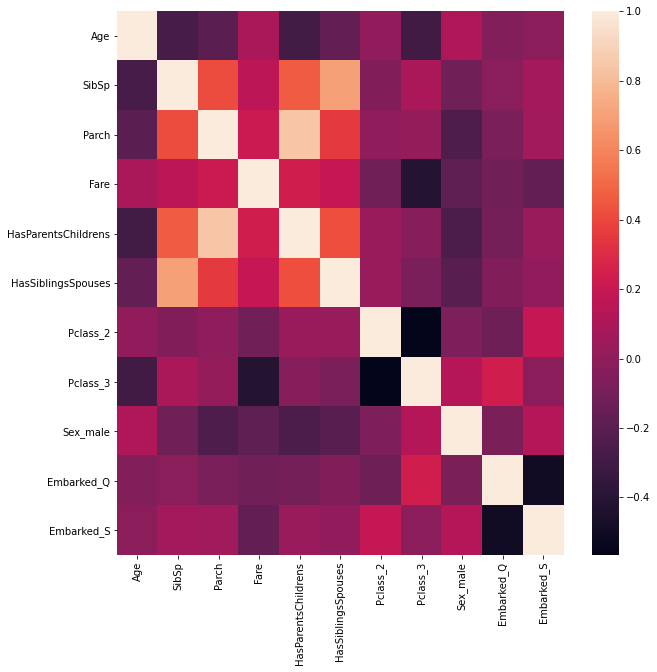

In [1548]:
# corr matrix for X
# we see that Pclass and Embarked and strongly correlated, but we already dropped one of three values during get_dummies
# decision whether to drop one more i left to algorithm
fig, ax = plt.subplots(figsize=(10,10))
heatmap(pd.DataFrame(X).corr());

In [1549]:
# features dropped (and we dropped every first of dummy when created it)
X.columns[(logreg_search.best_estimator_['clf'].coef_ == 0)[0]]

Index(['Embarked_Q'], dtype='object')

In [1550]:
# features selected
X.columns[(logreg_search.best_estimator_['clf'].coef_ != 0)[0]]

Index(['Age', 'SibSp', 'Parch', 'Fare', 'HasParentsChildrens',
       'HasSiblingsSpouses', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_S'],
      dtype='object')

In [1551]:
# and their coeffs
logreg_search.best_estimator_['clf'].coef_

array([[-0.5094697 , -0.74604204, -0.27192024,  0.09285639,  0.26563814,
         0.34660342, -0.37913481, -1.02160741, -1.23927809,  0.        ,
        -0.15984261]])

Now we can predict on test dataset

In [1552]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
# we have one missed value in Fare - just fix it with mean
test_data.loc[test_data['Fare'].isna(), 'Fare'] = test_data['Fare'].mean()
X_test = clean_data(test_data)
y_test_pred = logreg_search.predict(X_test)

In [1553]:
pd.DataFrame(y_test_pred, index=test_data.index, columns=['Survived']).to_csv('submission_muravyev_final.csv')

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Code above with fixed random seed gives score equal 0.78229. I will not copy all code to this section, just look it before :)

<img src="kaggle_submission.png">